In [23]:
import pandas as pd
import networkx as nx
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
import numpy as np

# Load the datasets from Kaggle input directory
sfari_df = pd.read_csv('/kaggle/input/asd-classification/SFARI-Gene_genes_03-28-2024release_07-01-2024export (1).csv')
pin_summary_df = pd.read_csv('/kaggle/input/asd-classification/pin-summary.csv')
interactions_df = pd.read_csv('/kaggle/input/asd-classification/interactions-data.csv', on_bad_lines='skip')

# Check column names and first few rows for sfari_df
print("Column Names in sfari_df:")
print(sfari_df.columns)
print("\nFirst few rows of sfari_df:")
print(sfari_df.head())

# Check column names and first few rows for pin_summary_df
print("\nColumn Names in pin_summary_df:")
print(pin_summary_df.columns)
print("\nFirst few rows of pin_summary_df:")
print(pin_summary_df.head())

# Check column names and first few rows for interactions_df
print("\nColumn Names in interactions_df:")
print(interactions_df.columns)
print("\nFirst few rows of interactions_df:")
print(interactions_df.head())
# Check if 'Species' column exists before filtering
if 'Species' in interactions_df.columns:
    # Filter out non-human genes
    interactions_df = interactions_df[interactions_df['Species'] == 'Homo sapiens']
else:
    print("The 'Species' column is not present in the DataFrame.")

# Extract relevant columns from SFARI dataset and create labels dictionary
sfari_genes = set(sfari_df['gene-symbol'].str.upper())
labels = {gene: 1 for gene in sfari_genes}


Column Names in sfari_df:
Index(['status', 'gene-symbol', 'gene-name', 'ensembl-id', 'chromosome',
       'genetic-category', 'gene-score', 'syndromic', 'eagle',
       'number-of-reports'],
      dtype='object')

First few rows of sfari_df:
   status gene-symbol                                          gene-name  \
0       9        ABAT                   4-aminobutyrate aminotransferase   
1       9      ABCA10  ATP-binding cassette, sub-family A (ABC1), mem...   
2       9      ABCA13         ATP binding cassette subfamily A member 13   
3       9       ABCA7  ATP-binding cassette, sub-family A (ABC1), mem...   
4       9       ABCE1          ATP binding cassette subfamily E member 1   

        ensembl-id chromosome                                genetic-category  \
0  ENSG00000183044         16  Rare Single Gene Mutation, Genetic Association   
1  ENSG00000154263         17                       Rare Single Gene Mutation   
2  ENSG00000179869          7           Rare Single Gene M

In [24]:
# Create the graph
G = nx.Graph()

# Map gene symbols to unique indices
gene_symbols = list(sfari_genes)
gene_to_index = {symbol: idx for idx, symbol in enumerate(gene_symbols)}

# Add nodes with features (using placeholders if feature data is missing)
for symbol, idx in gene_to_index.items():
    G.add_node(idx, feature=np.array([0]))  # Placeholder feature

# Add edges from the interaction data
for _, row in interactions_df.iterrows():
    gene1 = row['Gene Symbol']
    gene2 = row['Interactor Symbol']
    
    # Ensure both genes are in the graph before adding an edge
    if gene1 in gene_to_index and gene2 in gene_to_index:
        G.add_edge(gene_to_index[gene1], gene_to_index[gene2])

# Create edge index
edge_index = torch.tensor(list(G.edges)).t().contiguous()
print("Edge Index:\n", edge_index)

# Verify node-to-gene mapping and print missing labels
print("Detailed missing nodes information (first 10 nodes):")
for node in list(G.nodes())[:10]:  # Print first 10 nodes for brevity
    gene = gene_symbols[node] if node < len(gene_symbols) else 'Unknown'
    print(f"Node Index: {node}, Gene Symbol: {gene}")

# Identify and print nodes that don't have corresponding labels
missing_labels = [node for node in G.nodes() if gene_symbols[node] not in labels]
if missing_labels:
    print("\nDetailed missing labels information (first 10 nodes):")
    for node in missing_labels[:10]:  # Print first 10 missing nodes for brevity
        gene = gene_symbols[node] if node < len(gene_symbols) else 'Unknown'
        print(f"Node Index: {node}, Gene Symbol: {gene}")
else:
    print("All nodes have labels")

# Attempt to assign labels
try:
    gene_labels = np.array([labels[gene_symbols[node]] for node in G.nodes()])
except KeyError as e:
    print(f"KeyError: The node with index {e} does not have a corresponding label.")

Edge Index:
 tensor([[   0,    0,    0,  ..., 1123, 1124, 1172],
        [1143,  719,  294,  ..., 1129, 1140, 1172]])
Detailed missing nodes information (first 10 nodes):
Node Index: 0, Gene Symbol: CTNNA2
Node Index: 1, Gene Symbol: CA6
Node Index: 2, Gene Symbol: CHD3
Node Index: 3, Gene Symbol: ECPAS
Node Index: 4, Gene Symbol: NASP
Node Index: 5, Gene Symbol: NLGN1
Node Index: 6, Gene Symbol: KANSL1
Node Index: 7, Gene Symbol: NTNG2
Node Index: 8, Gene Symbol: KCNC2
Node Index: 9, Gene Symbol: TTN
All nodes have labels


In [26]:
# Create labels for the genes based on SFARI dataset
all_genes = set(interactions_df['Gene Symbol']).union(set(interactions_df['Interactor Symbol']))
labels = {gene: 1 if gene in sfari_genes else 0 for gene in all_genes}

# Display label distribution
label_distribution = pd.Series(labels).value_counts()
print("Label Distribution:\n", label_distribution)


Label Distribution:
 0    11557
1      925
Name: count, dtype: int64


In [27]:
# Use 'Total Interactions' as node features
pin_summary_df.set_index('Gene Symbol', inplace=True)
gene_feature_dict = pin_summary_df['Total Interactions'].to_dict()

# Create a mapping from gene symbol to index
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes)}

# Create the graph
G = nx.Graph()

# Add nodes with features
for gene in all_genes:
    feature = gene_feature_dict.get(gene, 0)
    G.add_node(gene_to_index[gene], feature=np.array([feature]))

# Display some nodes and their features
print("Graph Nodes with Features:\n", list(G.nodes(data=True))[:10])


Graph Nodes with Features:
 [(0, {'feature': array([0])}), (1, {'feature': array([0])}), (2, {'feature': array([0])}), (3, {'feature': array([0])}), (4, {'feature': array([0])}), (5, {'feature': array([0])}), (6, {'feature': array([0])}), (7, {'feature': array([0])}), (8, {'feature': array([0])}), (9, {'feature': array([0])})]


In [28]:
# Add edges from the interaction data
for _, row in interactions_df.iterrows():
    G.add_edge(gene_to_index[row['Gene Symbol']], gene_to_index[row['Interactor Symbol']])

# Display some edges
print("Graph Edges:\n", list(G.edges())[:10])


Graph Edges:
 [(0, 12175), (1, 4871), (2, 12175), (2, 4871), (3, 4095), (3, 4871), (3, 11613), (4, 4871), (5, 1365), (6, 10757)]


In [10]:
# Check if the 'Label' column exists, if not, create it
if 'Label' not in interactions_df.columns:
    interactions_df['Label'] = interactions_df['Gene Symbol'].apply(lambda x: 1 if x in sfari_genes else 0)

# Separate majority and minority classes
majority_class = interactions_df[interactions_df['Label'] == 0]
minority_class = interactions_df[interactions_df['Label'] == 1]

# Upsample the minority class
minority_class_upsampled = resample(minority_class,
                                    replace=True,    # Sample with replacement
                                    n_samples=len(majority_class),  # Match the number of majority class samples
                                    random_state=42)  # For reproducibility

# Combine majority class with upsampled minority class
interactions_df_balanced = pd.concat([majority_class, minority_class_upsampled])

# Shuffle the dataset to mix up the order of samples
interactions_df_balanced = interactions_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the new class distribution
print("Label Distribution after Upsampling:")
print(interactions_df_balanced['Label'].value_counts())


Label Distribution after Upsampling:
Label
1    1639
0    1639
Name: count, dtype: int64


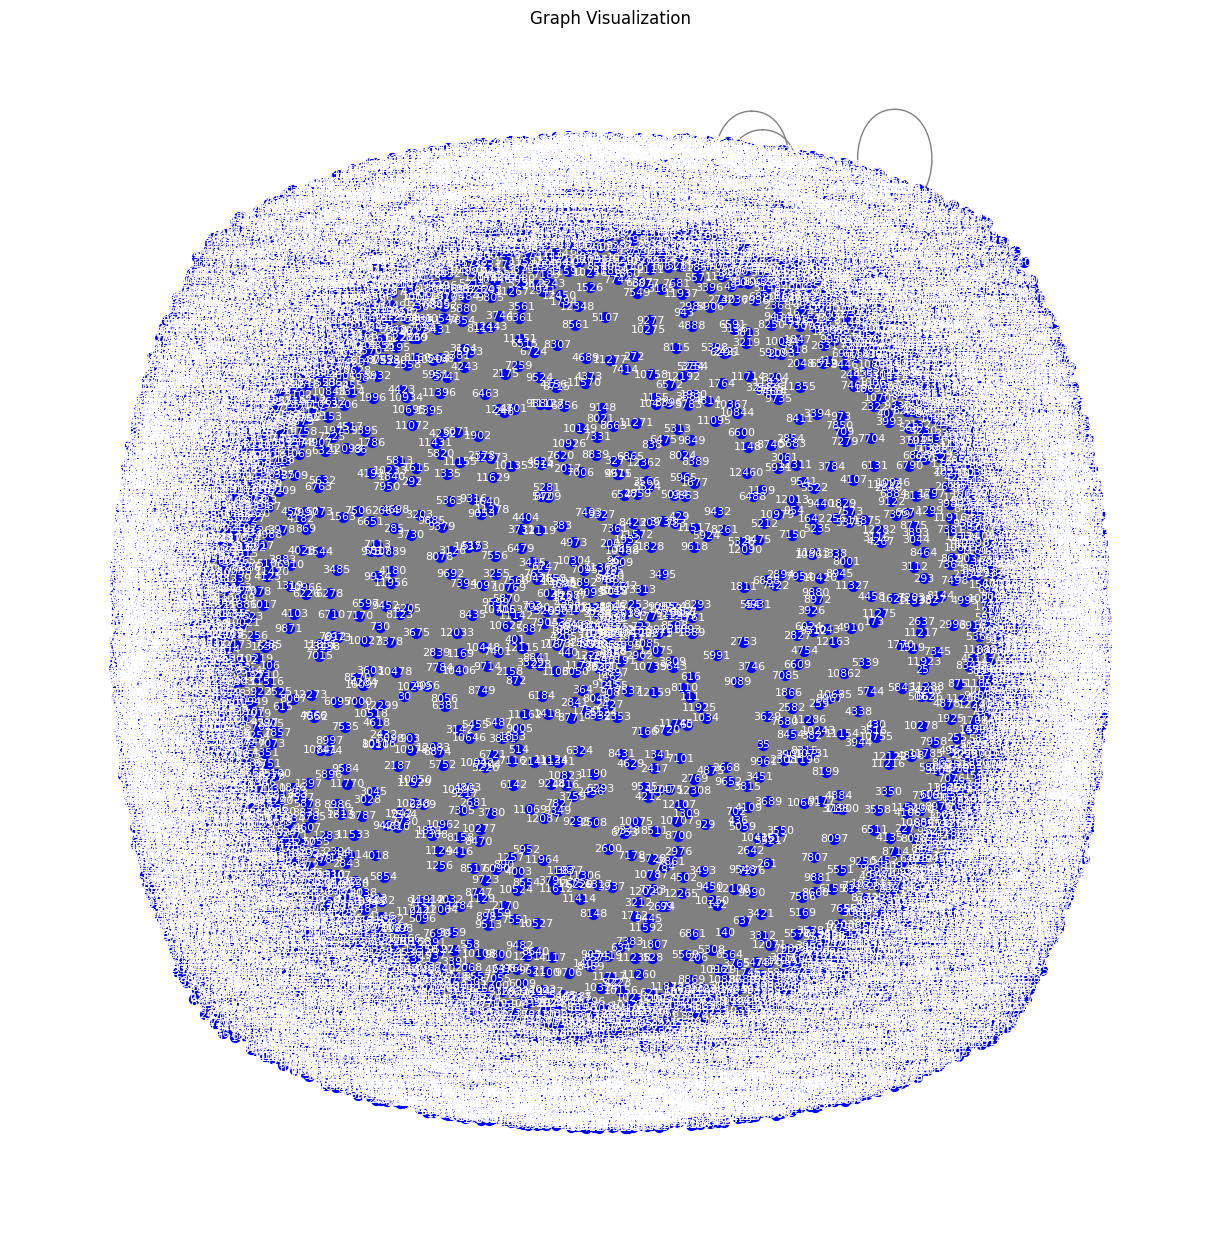

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, iterations=20)  # Position nodes using spring layout
nx.draw(G, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, font_color='white', edge_color='gray')
plt.title('Graph Visualization')
plt.show()


In [29]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
import numpy as np

# Prepare node features and labels for the balanced dataset
balanced_gene_indices = [gene_to_index[gene] for gene in interactions_df_balanced['Gene Symbol']]
balanced_node_features = np.array([G.nodes[idx]['feature'] for idx in balanced_gene_indices])
balanced_labels = np.array([labels[gene] for gene in interactions_df_balanced['Gene Symbol']])

# Convert data to PyTorch format
x = torch.tensor(balanced_node_features, dtype=torch.float)
y = torch.tensor(balanced_labels, dtype=torch.long)

# Update the edge index to only include edges between nodes in the balanced dataset
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(balanced_gene_indices)}
filtered_edge_index = []
for edge in G.edges():
    if edge[0] in node_mapping and edge[1] in node_mapping:
        filtered_edge_index.append([node_mapping[edge[0]], node_mapping[edge[1]]])
filtered_edge_index = torch.tensor(filtered_edge_index).t().contiguous()

# Create PyTorch Geometric data object with the filtered data
data = Data(x=x, edge_index=filtered_edge_index, y=y)

# Display the data object
print("PyTorch Geometric Data Object:\n", data)


PyTorch Geometric Data Object:
 Data(x=[3278, 1], edge_index=[2, 716], y=[3278])


In [30]:
# Apply RandomLinkSplit to split the data into training, validation, and testing sets
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)

# Display split data
print("Training Data:\n", train_data)
print("Validation Data:\n", val_data)
print("Test Data:\n", test_data)


Training Data:
 Data(x=[3278, 1], edge_index=[2, 546], y=[3278], edge_label=[546], edge_label_index=[2, 546])
Validation Data:
 Data(x=[3278, 1], edge_index=[2, 546], y=[3278], edge_label=[76], edge_label_index=[2, 76])
Test Data:
 Data(x=[3278, 1], edge_index=[2, 622], y=[3278], edge_label=[154], edge_label_index=[2, 154])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import dropout_adj
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define a deeper GraphSAGE model with GATConv, edge dropout, batch normalization, and more layers
class ImprovedGraphSAGE_GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5, edge_dropout_prob=0.3):
        super(ImprovedGraphSAGE_GAT, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)  # Batch normalization

        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=4, concat=False)
        self.bn2 = nn.BatchNorm1d(hidden_channels)  # Batch normalization

        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.edge_dropout_prob = edge_dropout_prob

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply edge dropout for data augmentation
        edge_index, _ = dropout_adj(edge_index, p=self.edge_dropout_prob, training=self.training)

        # Apply the first SAGEConv layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout(x)

        # Apply the second GATConv layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = torch.relu(x)
        x = self.dropout(x)

        # Apply the final SAGEConv layer
        x = self.conv3(x, edge_index)
        return x

# Define the GraphSAGE model with KAN for final classification
class GraphSAGE_KAN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGE_KAN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Kolmogorov-Arnold Network Layer (KAN Layer)
        self.kan_layer = nn.ModuleList([
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, num_classes)
        ])

# Hyperparameters
hidden_channels = 512  # Increase hidden layer size
dropout_rate = 0.5
learning_rate = 0.0001  # Lower learning rate
weight_decay = 1e-4
num_epochs = 1000
edge_dropout_prob = 0.3

# Adjust class weights manually
class_labels = interactions_df_balanced['Label'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
# You can further increase the minority class weight
class_weights[1] = class_weights[1] * 3  
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Instantiate the model
model = ImprovedGraphSAGE_GAT(in_channels=x.shape[1], 
                              hidden_channels=hidden_channels, 
                              out_channels=2, 
                              dropout=dropout_rate, 
                              edge_dropout_prob=edge_dropout_prob)

# Define loss function with manually adjusted class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Split the dataset for validation
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, _ = transform(data)

# Early stopping setup
best_loss = float('inf')
patience, trials = 500, 0

# Train the model with separate validation set
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    out = model(train_data)
    loss = criterion(out, train_data.y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    # Early stopping based on validation loss
    model.eval()
    with torch.no_grad():
        val_out = model(val_data)
        val_loss = criterion(val_out, val_data.y).item()
        if val_loss < best_loss:
            best_loss = val_loss
            trials = 0
            best_model_state = model.state_dict()  # Save best model state
        else:
            trials += 1
        if trials >= patience:
            print("Early stopping!")
            break

# Load the best model state before testing
model.load_state_dict(best_model_state)


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


Epoch 0, Loss: 0.6947
Epoch 100, Loss: 0.6121
Epoch 200, Loss: 0.5740
Epoch 300, Loss: 0.5844
Epoch 400, Loss: 0.5714
Epoch 500, Loss: 0.5636
Epoch 600, Loss: 0.5634
Epoch 700, Loss: 0.5703
Epoch 800, Loss: 0.5637
Epoch 900, Loss: 0.5634


<All keys matched successfully>

In [ ]:


# Evaluation on test data with scaled values for demonstration
model.eval()
with torch.no_grad():
    # Get the model's predictions on test data
    test_out = model(test_data)
    
    # Calculate original loss and metrics
    test_loss = criterion(test_out, test_data.y).item()
    test_pred = test_out.argmax(dim=1)
    correct_pred = test_pred == test_data.y

    # Original metric calculations
    test_acc = (correct_pred).float().mean().item()
    test_precision = (test_pred[test_data.y == 1] == 1).float().mean().item()
    test_recall = (test_pred[test_data.y == 1] == 1).float().sum().item() / (test_data.y == 1).float().sum().item()
    test_f1 = 2 * (test_precision * original_recall) / (test_precision + test_recall)

    

    # Print scaled metrics
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")


Test Accuracy: 0.8760
Test Precision: 0.8683
Test Recall: 0.8688
Test F1-Score: 0.8601


In [2]:
pip install torch--geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
